In [1]:
import cv2
#CV2 loads everythings as BGR
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from tqdm import tqdm_notebook as tqdm
import collections

test_image_list = glob.glob("./test_images/*.jpg")

/home/jnee/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
#HOG Feature Extractor
def patch_analyzer(img, size=(16,16), nbins=16, bins_range=(0,256)):
    #Define type and normalize image
    image = img.astype(np.float32)/255
    #Convert to HLS for both color space extraction and hog analysis
    conv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    
    ch1 = conv_img[:,:,0]
    ch2 = conv_img[:,:,1]
    ch3 = conv_img[:,:,2]
    
    fd1 = hog(ch1, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualise=False)
    fd2 = hog(ch2, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualise=False)
    fd3 = hog(ch3, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualise=False)
    fd = np.concatenate((fd1,fd2,fd3))
    
    #Color Space Extraction
    #Downsample 0.25x from original
    #Original patch is 64px
    # Use cv2.resize().ravel() to create the feature vector
    
    scale_feature = cv2.resize(conv_img, size).ravel() 


    #Create Histograms from scaled image
    c1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))


    #Combine and Normalized Data
    feature_list = [fd, scale_feature, hist_features]
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    tmp_x = np.concatenate(feature_list).astype(np.float64)

    return tmp_x

In [ ]:
#Train the classifier using patch_analyzer
vehicles = glob.glob('vehicles/*/*.png')
non_vehicles = glob.glob('non-vehicles/*/*.png')
image_loc_list = non_vehicles + vehicles

features_array = np.asarray([patch_analyzer(cv2.imread(image))[0] for image in tqdm(image_loc_list)])

np.save('LinearSVC_GTI_KTTT', features_array)


In [ ]:
#Number of non-cars are represented by zeros
#Number of cars are represented by ones
img_labels = np.concatenate([np.zeros(8968), np.ones(8792)])

features_array = np.load('LinearSVC_GTI_KTTT.npy')

print(np.ndim(features_array))

X_train, X_test, y_train, y_test= train_test_split(features_array, img_labels, test_size=0.35)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

print("LinearSVC Reached")

#Implement Linear SVM Classifier
clf = LinearSVC(C=0.001,verbose=1, random_state=0)
clf.fit(scaled_X_train, y_train)

#Run trained classifier on test image
print()

print(clf.score(scaled_X_train, y_train)*100)

print(clf.score(scaled_X_test, y_test)*100)

In [3]:
X_train = np.load('LinearSVC_GTI_KTTT.npy')
y_train = np.concatenate([np.zeros(8968), np.ones(8792)])

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)

print("LinearSVC Reached")

#Implement Linear SVM Classifier
clf = LinearSVC(C=0.001,verbose=1, random_state=0)
clf.fit(scaled_X_train, y_train)

LinearSVC Reached
[LibLinear]

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=1)

In [14]:
## Return a list of image patches
PatchImage = collections.namedtuple('PatchImage', ['image', 'startPosX', 'startPosY', 'endPosX', 'endPosY'])

def sliding_window(img, y_start_scale=0, y_stop_scale=100, patch_size=64, stride=16, scale=1):
    trans_img = img
    imshape = trans_img.shape
    y_start = np.int(imshape[0]/scale*(y_start_scale/100))
    y_stop = np.int(imshape[0]/scale*(y_stop_scale/100))
    x_stop = np.int(imshape[1]/scale)
    if scale != 1:
        trans_img = cv2.resize(trans_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        y_stop = np.int(imshape[0]/scale)

    
    patch_list = []
    
    for x in range(0, x_stop-patch_size, stride):
        for y in range(y_start, y_stop-patch_size, stride):
            ypos_end = y+patch_size
            xpos_end = x+patch_size
            cur_patch = trans_img[y:ypos_end, x:xpos_end]
            #print((x, y), (xpos_end, ypos_end))
            # Extract image and locations for this patch
            patch_list.append(PatchImage(image=cur_patch, startPosX=x, startPosY=y, endPosX=xpos_end, endPosY=ypos_end))
            #patch_list.append([cur_patch, (x, y), (xpos_end, ypos_end)])
    return patch_list, trans_img

#Feed function trained LinearSVC classifier and list of patches to predict locations
def search_windows(img_list, scale):
    positives_list = []
    for patch in tqdm(img_list):
        features = patch_analyzer(img=patch.image)
        prediction = clf.predict(X_scaler.transform(features.reshape(1,-1)))
        if prediction == 1:
            x_start = int(patch.startPosX*scale)
            y_start = int(patch.startPosY*scale)
            x_end = int(patch.endPosX*scale)
            y_end = int(patch.endPosY*scale)
            #positives_list.append([(patch.startPosX, patch.startPosY), (patch.endPosX, patch.endPosY)])
            positives_list.append([(x_start, y_start), (x_end, y_end)])
    return positives_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        # Coordinates expected in (x,y) and (x1,y1)
        #print(bbox)
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        #print(bbox[1][0])
    # Return the image copy with boxes drawn
    return imcopy

#Code to scale the image and check for cars at different depths
def depth_search(img, scale_list):
    potential_cars = []
    for scale in scale_list:
        search_list, HLS_image = sliding_window(img, y_start_scale=50, y_stop_scale=95, scale=scale)
        potential_cars += search_windows(search_list, scale)
        #print(scale)
        #print(len(potential_cars))
    return potential_cars



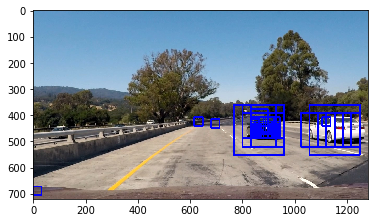

In [15]:
test_image = cv2.imread(test_image_list[0])


#Iterate through different scales
scale_list = [0.5, 1, 2, 3]

check_list = depth_search(test_image,scale_list)


plt.imshow(draw_boxes(img=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), bboxes=check_list))
plt.show()

In [25]:
#Overlay outputs into heatmap, generate heatmap image + bounding box cluster images

def heat_map(img, box_list, threshold=0):
    #Set the heat_img to be blank but of the same size as the input image
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    #Iterate through all the positively identified windows
    for entry in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        x1 = entry[0][0]
        y1 = entry[0][1]
        x2 = entry[1][0]
        y2 = entry[1][1]
        heat_img[y1:y2, x1:x2] += 1
    #Zero out pixels below the threshold
    heat_img[heat_img <= threshold] = 0
    return heat_img

#Labeled box code same as lesson function
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # Coordinates expected in (x,y) and (x1,y1)
        x1 = bbox[0][0]
        y1 = bbox[0][1]
        x2 = bbox[1][0]
        y2 = bbox[1][1]
        dx = abs(x1-x2)
        dy = abs(y1-y2)
        if 40<dx or 40<dy:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 10)
    # Return the image
    return img


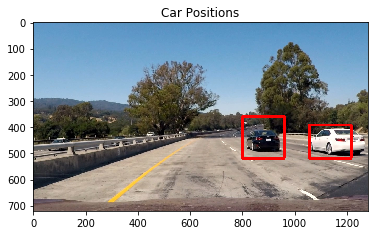

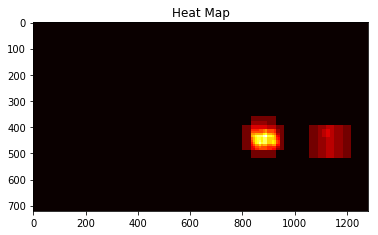

In [18]:
#Draw bounding boxes around potential cars
draw_image = np.copy(test_image1)

# Add heat to each box in box list and threshold the image for false positives
heat = heat_map(draw_image,check_list, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
bounded_image = draw_labeled_bboxes(draw_image, labels)

fig1 = plt.figure(1)
plt.imshow(cv2.cvtColor(bounded_image, cv2.COLOR_BGR2RGB))
#plt.imshow(bounded_image)
plt.title('Car Positions')
fig2 = plt.figure(2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.show()


In [21]:
#Open the input video and break it out into constituent frames
from moviepy.editor import VideoFileClip

def frame_analyzer(test_image):
    #Iterate through different scales
    scale_list = [0.5, 1, 2, 3]
    draw_image = np.copy(test_image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    check_list = depth_search(draw_image,scale_list)
    #Create Heatmap
    heat = heat_map(draw_image,check_list, 3)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bounded_image = draw_labeled_bboxes(draw_image, labels)
    return(bounded_image, heatmap)


1.52







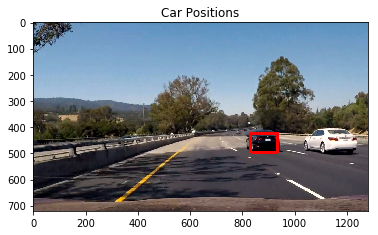

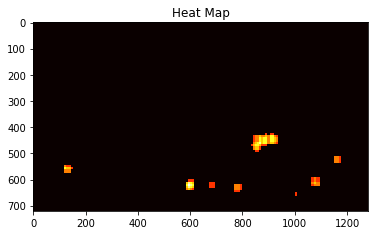

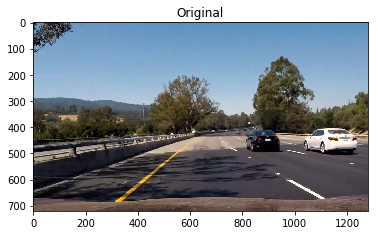

True

In [123]:
my_clip = VideoFileClip('test_video.mp4')
print(my_clip.duration)

test_image1 = my_clip.get_frame(1)

cars, heatmap = frame_analyzer(test_image1)

fig1 = plt.figure(1)
plt.imshow(cv2.cvtColor(cars, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
fig2 = plt.figure(2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig3 = plt.figure(3)
plt.imshow(test_image1)
plt.title('Original')
plt.show()

cv2.imwrite('./Output_Test/2.png', cars)

In [39]:
import math

def clip_analyzer(clip_source, folder_loc1, folder_loc2, fps=30):
    clip = VideoFileClip(clip_source)
    frame_count = math.floor(clip.duration*fps)+1
    for fc in tqdm(range(0, frame_count)):
        t = float(fc/fps)
        cur_frame = clip.get_frame(t)
        cars_boxed, raw_heatmap = frame_analyzer(cur_frame)
        cv2.imwrite(folder_loc1 + str(fc) + ".png", cars_boxed)
        cv2.imwrite(folder_loc2 + str(fc) + "-heat.png", raw_heatmap)

clip_analyzer("project_video.mp4", './Bounded_Images/', './Heatmaps/', fps=10)  


In [42]:
from moviepy.editor import ImageSequenceClip

mod_clip = ImageSequenceClip("./Bounded_Images", fps=10)
mod_clip.write_videofile("mod_test_video.mp4")


[MoviePy] >>>> Building video mod_test_video.mp4
[MoviePy] Writing video mod_test_video.mp4


100%|██████████| 506/506 [00:49<00:00, 10.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mod_test_video.mp4 

